# MedImageParse Fine-tuning Pipeline

This notebook demonstrates a complete end-to-end workflow for fine-tuning the MedImageParse model using Azure Machine Learning. The pipeline includes:

1. **Data Management**: Uploading training data and configuration files to Azure ML
2. **Pipeline Execution**: Running the fine-tuning job on Azure ML compute
3. **Model Deployment**: Deploying the fine-tuned model as a managed online endpoint
4. **Validation**: Testing the deployed model with sample medical images

## Prerequisites:
- Azure ML workspace configured
- Download training data to the same location as the medimageparse_finetuning.ipynb notebook --> https://huggingface.co/datasets/microsoft/BiomedParseData/blob/main/CDD-CESM.zip
- ⚠️ IMPORTANT: You need to have a huggingface account and be logged in for downloading the dataset!


## Setup and Authentication

This section handles the initial setup including:
- Importing required Azure ML SDK components and other dependencies
- Establishing authentication with Azure using DefaultAzureCredential
- Creating the MLClient instance for interacting with Azure ML services

create a config.json file in the following format:
```
{
       "subscription_id": "my-subscription-id",
       "resource_group": "my-resourcegroup-name",
       "workspace_name": "my-workspace-name"
   }
```

In [34]:
from azure.ai.ml import MLClient, load_component
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data, Environment, BuildContext, AmlCompute, Model
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml.dsl import pipeline
import random
import os
from dotenv import load_dotenv
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
)
import json
import base64
import matplotlib.pyplot as plt
import numpy as np
from azure.core.exceptions import ResourceNotFoundError

credentials = DefaultAzureCredential()
ml_client = MLClient.from_config(credentials)
ml_registry = MLClient(credential=credentials, registry_name="azureml")

Found the config file in: .\config.json


# Upload Data

This section creates and registers data assets in Azure ML that will be used for fine-tuning:

- **training_data**: The CDD-CESM dataset containing medical images and corresponding masks for training. Expected folder structure:

```
.
└── CCD-CESM/
    ├── test/
    │   └── xxx.png
    ├── test_mask/
    │   └── xxx.png
    ├── train/
    │   └── xxx.png
    ├── train_mask/
    │   └── xxx.png
    ├── test.json
    └── train.json
```
- **parameters**: Configuration file that defines training parameters, and other settings

The finetuning data asset is registered as a URI_FOLDER type, whereas the parameters file is registered as URI_FILE type, making them reusable across different experiments and pipelines. Azure ML automatically versions these assets, allowing for reproducible experiments.

In [ ]:
name = "medimageparse"

# Create and upload training data folder
training_data = Data(
    path="CDD-CESM",
    type=AssetTypes.URI_FOLDER,
    description=f"{name} training data",
    name=f"{name}-training_data",
)
training_data = ml_client.data.create_or_update(training_data)
print(
    f"Data asset training_data created or updated.",
    training_data.name,
    training_data.version,
)

# Create and upload parameters file
parameters = Data(
    path="parameters.yaml",
    type=AssetTypes.URI_FILE,
    description=f"{name} parameters",
    name=f"{name}-parameters",
)
parameters = ml_client.data.create_or_update(parameters)
print(
    f"Data asset parameters created or updated.",
    parameters.name,
    parameters.version,
)

# Store references for later use
data_assets = {
    "training_data": training_data,
    "parameters": parameters,
}

# Create and run Pipeline

## Select / Create Compute

This section manages the compute resources needed for fine-tuning:

- **GPU Compute**: Uses Standard_NC40ads_H100_v5 instances with powerful H100 GPUs.
- **Conditional Creation**: Only creates new compute if it doesn't already exist
- **Resource Management**: Automatically scales down when not in use to minimize costs

The H100 GPUs are specifically chosen for their excellent performance with large language models and computer vision tasks.

In [ ]:
compute_name = "gpucluster"

try:
    compute = ml_client.compute.get(name=compute_name)
except ResourceNotFoundError:
    compute_cluster = AmlCompute(
        name=compute_name,
        description="GPU cluster compute for fine-tuning",
        min_instances=1,
        max_instances=2,
        size="Standard_NC40ads_H100_v5",
    )
    compute = ml_client.compute.begin_create_or_update(compute_cluster).result()

## Pipeline Setup and Execution

This section handles the core pipeline creation and execution:

1. **Registry Access**: Connects to the Azure ML registry to access pre-trained models
2. **Data Asset loading**: Retrieves the latest version of the fine-tuning data assets
3. **Component Loading**: Retrieves the latest version of the fine-tuning component
4. **Pre-trained Model**: Fetches the latest MedImageParse model from the Azure ML registry
5. **Pipeline Definition**: Creates a pipeline that combines all components with proper input/output mapping
6. **Job Submission**: Submits the pipeline job to Azure ML with experiment tracking

In [ ]:
# Get the pipeline component
finetune_pipeline_component = ml_registry.components.get(
    name="medimageparse_finetune", label="latest"
)
print(
    "Component loaded",
    finetune_pipeline_component.name,
    finetune_pipeline_component.version,
)

# Get the latest MIP model
model = ml_registry.models.get(name="MedImageParse", label="latest")


@pipeline(name="medimageparse_finetuning" + str(random.randint(0, 100000)))
def create_pipeline():
    mip_pipeline = finetune_pipeline_component(
        pretrained_mlflow_model=model.id,
        data=data_assets["training_data"].id,
        config=data_assets["parameters"].id,
    )
    return {"mlflow_model_folder": mip_pipeline.outputs.mlflow_model_folder}


pipeline_object = create_pipeline()
pipeline_object.compute = compute.name
pipeline_object.settings.continue_on_step_failure = False
pipeline_job = ml_client.jobs.create_or_update(
    pipeline_object, experiment_name="medimageparse_finetune_experiment"
)
pipeline_job_run_id = pipeline_job.name
pipeline_job

### Monitor Pipeline Job

This cell displays the pipeline job details including:
- Job status and progress
- Links to view the job in Azure ML Studio
- Job ID for future reference
- Real-time updates on training progress

You can click on the Studio link to monitor training metrics, logs, and resource utilization in real-time.

# Deploy Fine-tuned Model

This section handles the deployment of the fine-tuned model as a managed online endpoint:

## Key Steps:
1. **Model Registration**: Register the fine-tuned model from the pipeline output
2. **Endpoint Creation**: Create a managed online endpoint for real-time inference
3. **Deployment Configuration**: Set up the deployment with appropriate compute resources
4. **Resource Allocation**: Use GPU instances for optimal inference performance

The deployment creates a REST API endpoint that can be called for real-time medical image segmentation and analysis.

In [38]:
# Run this cell if you reconnected to the notebook.

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

credentials = DefaultAzureCredential()
ml_client = MLClient.from_config(credentials)

if "pipeline_job_run_id" not in locals():
    ##  Retrieved by checking the json of the parent job in AzureML studio (under "See all properties") or in output of the cell where you started the job under "Name".
    pipeline_job_run_id = ""

if not len(pipeline_job_run_id):
    raise ValueError(
        "Your kernel may have died! You need to set the pipeline_job_run_id manually from the output above (job name), or from the experiment in AzureML portal."
    )

pipeline_job = ml_client.jobs.get(name=pipeline_job_run_id)

Found the config file in: .\config.json


## Model Registration and Endpoint Deployment

This section performs the actual model registration and endpoint deployment:

### Model Registration:
- **Output Path**: References the pipeline job output containing the fine-tuned model
- **MLflow Format**: Uses MLflow model format for easy deployment and versioning
- **Unique Naming**: Creates a unique model name combining project name and job ID

### Endpoint Creation:
- **Managed Endpoint**: Creates a managed online endpoint for easy scaling and management
- **GPU Deployment**: Uses Standard_NC40ads_H100_v5 for optimal inference performance. Standard_NC24ads_A100_v4 would also work.
- **Single Instance**: Starts with 1 instance, can be scaled up based on demand

⚠️ **Note**: This process can take 10-15 minutes to complete as Azure provisions the compute resources and deploys the model.

In [ ]:
run_model = Model(
    path=f"azureml://jobs/{pipeline_job.name}/outputs/mlflow_model_folder",
    name=f"MIP-{name}-{pipeline_job.name}",
    description="Model created from run.",
    type=AssetTypes.MLFLOW_MODEL,
)

# Register the Model
run_model = ml_client.models.create_or_update(run_model)

# Create endpoint and deployment with the classification model
endpoint = ManagedOnlineEndpoint(name=name)
endpoint = ml_client.online_endpoints.begin_create_or_update(endpoint).result()
deployment = ManagedOnlineDeployment(
    name=name,
    endpoint_name=endpoint.name,
    model=run_model.id,
    instance_type="Standard_NC40ads_H100_v5",
    instance_count=1,
)
deployment = ml_client.online_deployments.begin_create_or_update(deployment).result()

Check: endpoint medimageparse exists


.....................................................................................................................................

# Validate Deployment

This section tests the deployed model to ensure it's working correctly:

## Test Process:
1. **Sample Data Preparation**: Load a test mammography image from the CDD-CESM dataset
2. **Request Formatting**: Convert the image to base64 encoding and create a properly formatted JSON request
3. **Text Prompt**: Include a text description to guide the model's segmentation task
4. **API Call**: Send the request to the deployed endpoint
5. **Results Visualization**: Display the original image alongside the generated segmentation masks

In [40]:
def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


sample_image = os.path.join("./CDD-CESM/test", "P3_L_CM_CC_mammography_breast.png")
data = {
    "input_data": {
        "columns": ["image", "text"],
        "index": [0],
        "data": [
            [
                base64.encodebytes(read_image(sample_image)).decode("utf-8"),
                "neoplastic cells in breast pathology & inflammatory cells",
            ]
        ],
    }
}
data_json = json.dumps(data)

# Create request json
request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(data, request_file)

In [41]:
def decode_json_to_array(json_encoded):
    """Decode an image pixel data array in JSON.
    Return image pixel data as an array.
    """
    # Parse the JSON string
    array_metadata = json.loads(json_encoded)
    # Extract Base64 string, shape, and dtype
    base64_encoded = array_metadata["data"]
    shape = tuple(array_metadata["shape"])
    dtype = np.dtype(array_metadata["dtype"])
    # Decode Base64 to byte string
    array_bytes = base64.b64decode(base64_encoded)
    # Convert byte string back to NumPy array and reshape
    array = np.frombuffer(array_bytes, dtype=dtype).reshape(shape)
    return array


def plot_segmentation_masks(original_image, segmentation_masks):
    """Plot a list of segmentation mask over an image."""
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")

    for i, mask in enumerate(segmentation_masks):
        ax[i + 1].imshow(original_image)
        ax[i + 1].set_title(f"Mask {i+1}")
        mask_temp = original_image.copy()
        mask_temp[mask > 128] = [255, 0, 0, 255]
        mask_temp[mask <= 128] = [0, 0, 0, 0]
        ax[i + 1].imshow(mask_temp, alpha=0.9)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


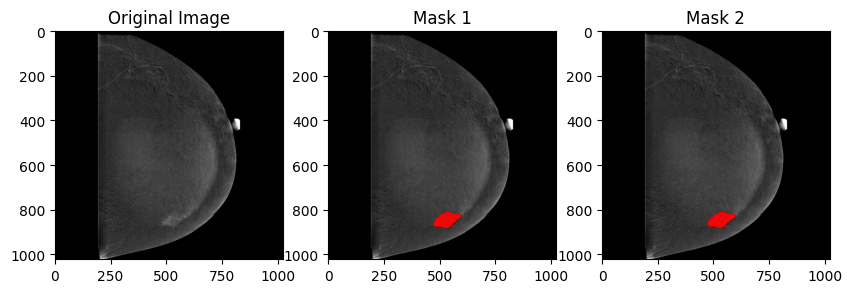

In [42]:
response = ml_client.online_endpoints.invoke(
    endpoint_name="medimageparse",
    deployment_name="medimageparse",
    request_file=request_file_name,
)
result_list = json.loads(response)
image_features_str = result_list[0]["image_features"]
image_features = decode_json_to_array(image_features_str)

# Plot feature over image
sample_image_arr = plt.imread(sample_image)
plot_segmentation_masks(sample_image_arr, image_features)

In [31]:
_ = ml_client.online_endpoints.begin_delete(name=endpoint.name).wait()

...............................................................